In [1]:
import matplotlib
#matplotlib.use('TKagg')
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
import pandas as pd
import json 
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def json_load(filename):
   with open(filename) as f_in:
       return(json.load(f_in)["mean"]["point_estimate"])

In [3]:
def load_files(dirname):
    folders = os.listdir(dirname)
    #print(folders)
    csv_files = list(map(lambda name: os.path.join(os.path.join(dirname, name),'new/raw.csv'), folders))

    #print(csv_files)


    df_from_each_file = (pd.read_csv(f, sep=',') for f in csv_files)
    #print(list(df_from_each_file))
    df_from_each_file = (f.head(1) for f in df_from_each_file)
    #print(list(df_from_each_file))
    return df_from_each_file


In [4]:
def size_calculation(value):
    element_size = int(value.split("-")[0])
    vector_size = int(value.split("-")[1])
    matrixs_size =  (((32 * element_size * element_size) * 3) * 2) * vector_size
    #normal_elements_size = ((6 * 32 * 1000) + (2 * 32 * 1000) + (6 * 32)) * vector_size
   
    return matrixs_size /8

In [5]:
def merge_csvs(directory):
    dirname = directory

    df_from_each_file = list(load_files(dirname)) 
    df_merged   = pd.concat(df_from_each_file, ignore_index=True)
        

    del df_merged["group"]
    del df_merged["throughput_type"]
    del df_merged["sample_measured_value"]
    del df_merged["unit"]
    del df_merged["iteration_count"]
    folders = df_merged['value']

    df_merged["time"] = list(map(lambda name: json_load(os.path.join(os.path.join(dirname, name),'new/estimates.json')), folders))

    time = df_merged['time']
    value = df_merged['value']
    del df_merged["throughput_num"]
    df_merged['element_size'] = list(map(lambda size:  int(size.split("-")[0]),value))
    df_merged['vector_size'] = list(map(lambda size: int(size.split("-")[1]),value))
    df_merged["throughput_num"] = list(map(lambda v: size_calculation(v), value))
    df_merged['time'] = list(map(lambda value: value/1000000, time))
    df_merged["throughput"] = list(map(lambda ab: float(ab[0]/ab[1]) ,list(zip(df_merged["throughput_num"], df_merged['time']))))
    df_merged['size'] = list(map(lambda value: value/(1024**2), df_merged["throughput_num"]))
    
    entry = df_merged.head().iloc[0]
    
    if entry['function'] == 'tokio' or entry['function'] == 'tokio_seq' :
        values = df_merged[df_merged.value.str.contains(r".*-36$")]
        values['value'] = list(map(lambda v: v.split("-")[0]+'-'+ v.split("-")[1] ,values['value']))
        return values
    
    
    return df_merged



def get_csv(directory):
    dirname = directory
    df_merged = (pd.read_csv(dirname, sep=','))
    print(df_merged)
    time = df_merged['time']
    value = df_merged['value']
    df_merged['element_size'] = list(map(lambda size:  int(size.split("-")[0]),value))
    df_merged['vector_size'] = list(map(lambda size: int(size.split("-")[1]),value))
    df_merged["throughput_num"] = list(map(lambda v: size_calculation(v), value))
    df_merged["throughput"] = list(map(lambda ab: float(ab[0]/ab[1]) ,list(zip(df_merged["throughput_num"], df_merged['time']))))
    df_merged['size'] = list(map(lambda value: value/(1024**2), df_merged["throughput_num"]))
    df_merged['function'] = "taskflow"
    
    
    
    return df_merged



In [6]:
directories = [
#"./benchmarks_schedulers/sequential"
"./benchmarks_schedulers/sequential_par_iter"
#,"./benchmarks_schedulers/sequential_for_loop"
#,"./benchmarks_schedulers/parallel_speculative_iter"
#,"./benchmarks_schedulers/parallel_speculative_par_iter"
#,"./benchmarks_schedulers/speculative"
,"./benchmarks_schedulers/async"
,"./benchmarks_schedulers/tokio"
#,"./benchmarks_schedulers/tokio_seq"
]

csv =  get_csv("./taskflow/bench.csv")
csvs = list(map(lambda dir:merge_csvs(dir), directories))
csvs.append(csv)
#files = [csv[0], csvs]
#csvs = pd.concat(files , ignore_index=True)

        value  time
0       32-24    41
1       32-48    90
2       32-96   196
3      32-120   254
4      32-240   492
..        ...   ...
71   1024-360   720
72   1024-600  1268
73   1024-800  1599
74  1024-1200  2675
75  1024-2400  5349

[76 rows x 2 columns]


<ipython-input-5-2657b80239f9>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  values['value'] = list(map(lambda v: v.split("-")[0]+'-'+ v.split("-")[1] ,values['value']))


In [7]:
#common_values = list(set(df1.Col1) & set(df2.Col1) & set(df3.Col1))
from functools import reduce

values = list(reduce(lambda acc,v: acc & set(v['value']) ,csvs,set(csvs[0]['value'])))

print(list(values))
#l = csvs[0].loc[csvs[0]['value'].isin(values)]
#print(l)

l = list(map(lambda value: value.loc[value['value'].isin(values)]  ,csvs))

l = list(map(lambda value: value.sort_values(by=["size"], ascending=False)  ,l))
time_ord = list(map(lambda value: value.sort_values(by=["time"], ascending=False)  ,l))



['128-800', '128-96', '128-12', '256-24', '64-4800', '64-1200', '128-120', '32-1200', '32-120', '64-96', '512-360', '256-600', '128-48', '64-24', '128-12000', '512-48', '512-120', '64-12000', '64-800', '256-800', '256-2400', '512-96', '256-96', '128-2400', '256-12', '32-96', '32-12000', '256-1200', '128-360', '32-2400', '128-24', '32-48', '32-9600', '128-9600', '64-12', '64-240', '32-240', '512-600', '32-600', '256-120', '32-24', '256-240', '128-600', '64-600', '128-240', '64-48', '128-1200', '32-4800', '256-9600', '512-24', '64-9600', '256-4800', '32-360', '512-240', '512-12', '256-12000', '256-48', '64-2400', '64-360', '64-120', '128-4800', '256-360', '512-800', '32-800']


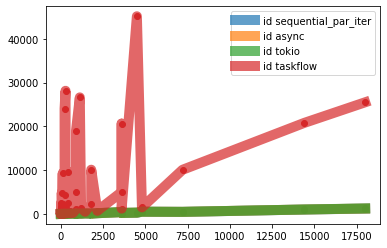

In [8]:
for v  in l :
    plt.scatter(v['size'],v['time'])

    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["axes.labelsize"] = 2
#plt.xscale('log',base=2) 
#plt.yscale('log',base=2) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    


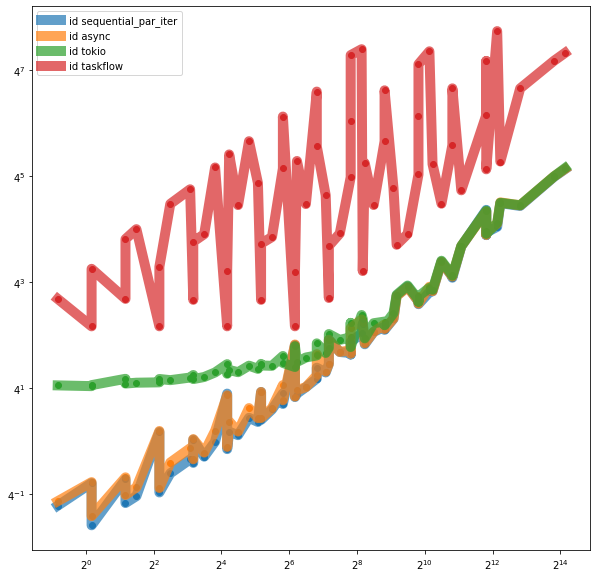

In [9]:
for v  in l :
    plt.scatter(v['size'],v['time'])
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
#plt.rcParams["axes.labelsize"] = 5

plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    

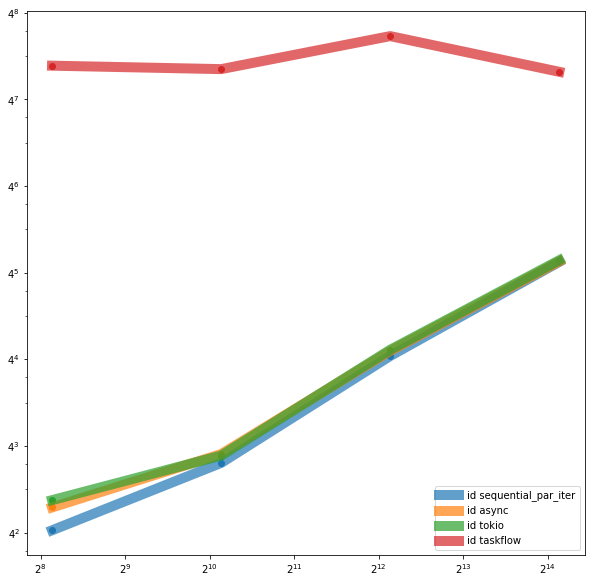

In [10]:
# 256-12000
a = list(map(lambda value: value[value.value.str.contains(r"^.*-12000")],l))

for v  in a :
    plt.scatter(v['size'],v['time'])
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    

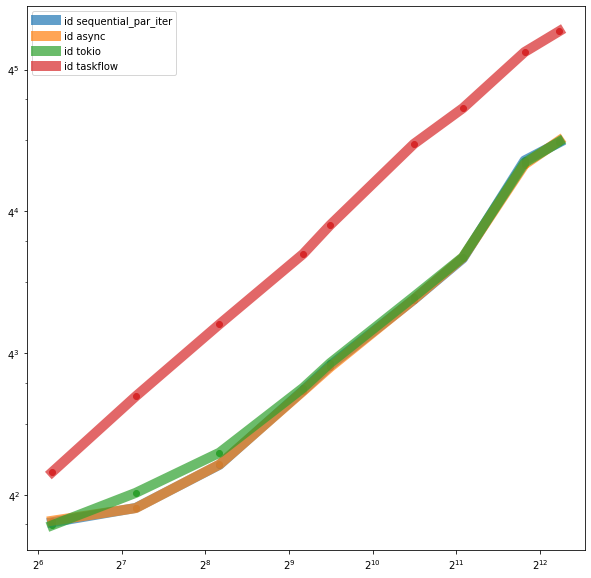

In [11]:
# 512-800

b = list(map(lambda value: value[value.value.str.contains(r"^512-.*")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'])
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    

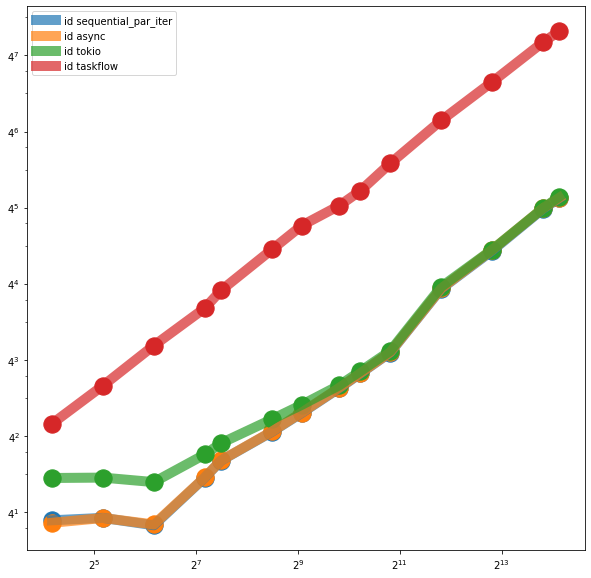

In [12]:
# 512-800

b = list(map(lambda value: value[value.value.str.contains(r"^256-.*")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    

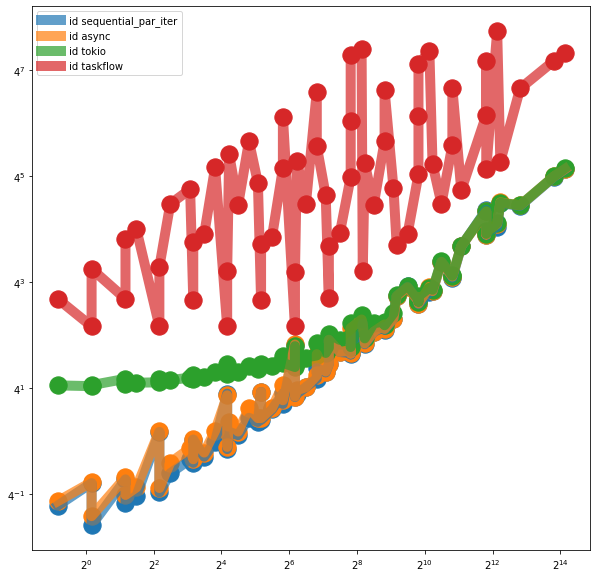

In [13]:
for v  in l :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["axes.labelsize"] = 25
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    

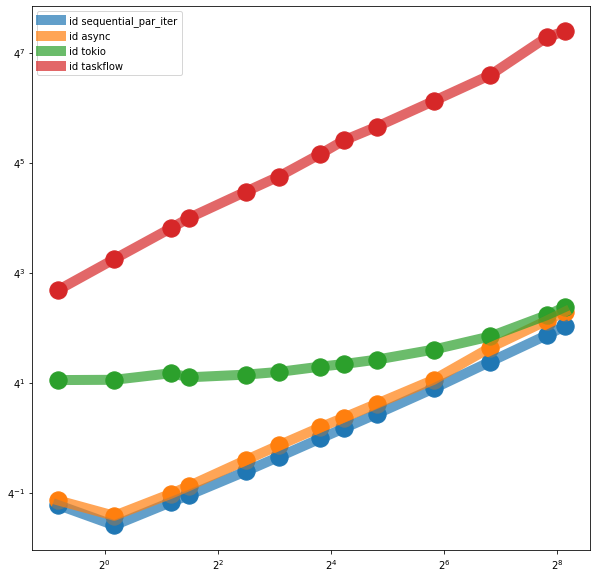

In [14]:
b = list(map(lambda value: value[value.value.str.contains(r"^32-.*")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    

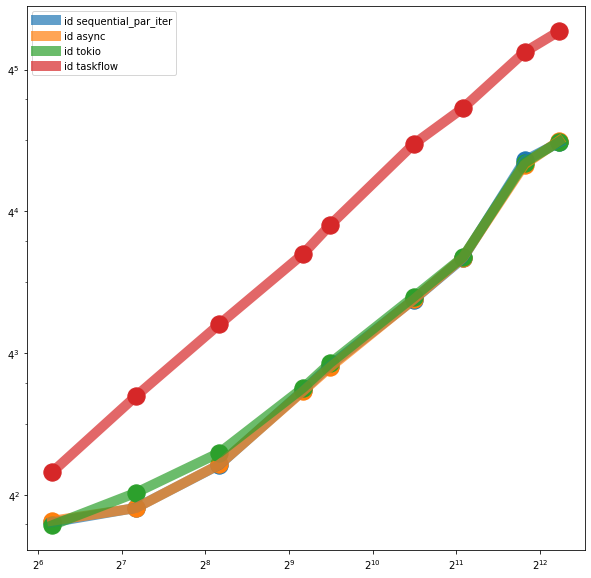

In [15]:
b = list(map(lambda value: value[value.value.str.contains(r"^512-.*")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    

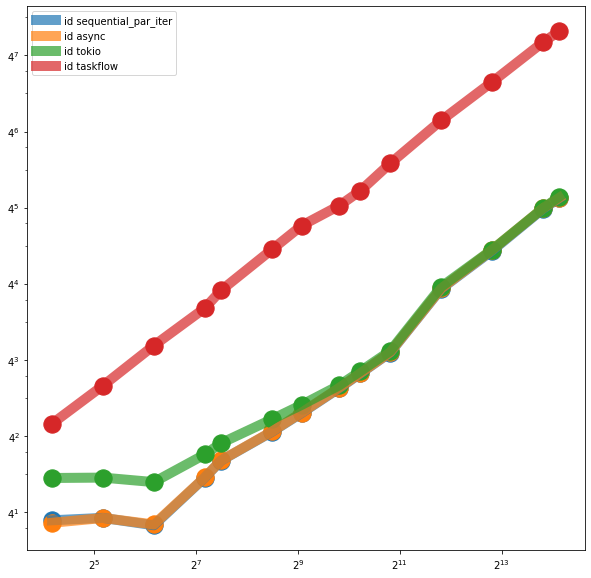

In [16]:
b = list(map(lambda value: value[value.value.str.contains(r"^256-.*")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    

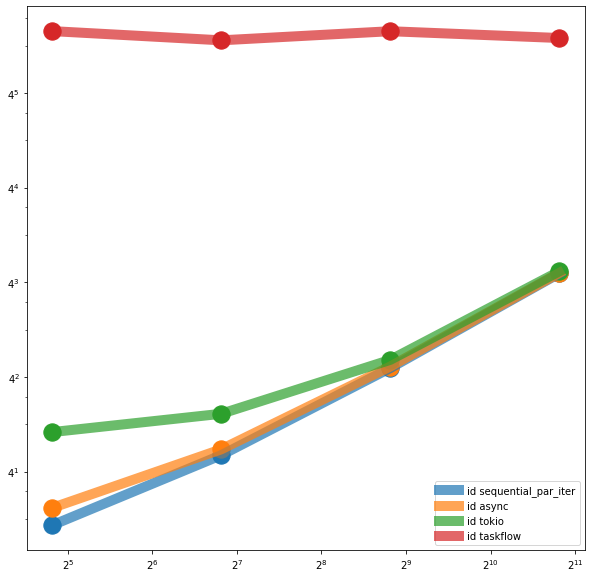

In [17]:
#['512-600', '64-800', '64-96', '512-24', '32-1200', 
# '128-240', '32-4800', '32-12', '128-1200', '256-48', '64-360', '512-48', 
# '32-12000', '128-600', '256-24', '128-48', '128-2400', '128-120', '32-240', 
# '32-120', '128-9600', '64-120', '512-120', '256-2400', '256-4800', '512-96', 
# '64-2400', '256-120', '64-600', '128-96', '32-9600', '32-2400', '256-96', '256-600', 
# '32-24', '128-12', '64-4800', '256-12', '32-48', '32-600', '128-24', '64-24', '64-48', 
# '32-96', '256-240', '64-9600', '64-240', '32-360', '64-12000', '512-12', '256-9600', 
# '64-1200', '64-12', '256-800', '256-360', '128-4800', '512-360', '256-1200', '512-240', 
# '128-800', '512-800', '128-360', '32-800', '128-12000', '256-12000']



b = list(map(lambda value: value[value.value.str.contains(r",*-1200$")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    

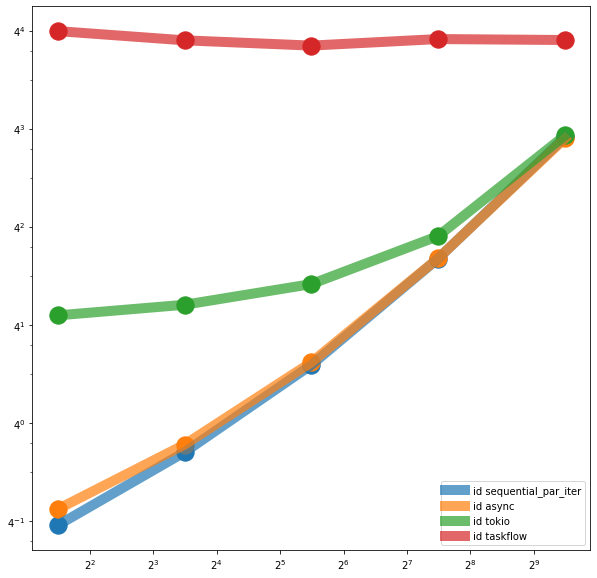

In [18]:
#['512-600', '64-800', '64-96', '512-24', '32-1200', 
# '128-240', '32-4800', '32-12', '128-1200', '256-48', '64-360', '512-48', 
# '32-12000', '128-600', '256-24', '128-48', '128-2400', '128-120', '32-240', 
# '32-120', '128-9600', '64-120', '512-120', '256-2400', '256-4800', '512-96', 
# '64-2400', '256-120', '64-600', '128-96', '32-9600', '32-2400', '256-96', '256-600', 
# '32-24', '128-12', '64-4800', '256-12', '32-48', '32-600', '128-24', '64-24', '64-48', 
# '32-96', '256-240', '64-9600', '64-240', '32-360', '64-12000', '512-12', '256-9600', 
# '64-1200', '64-12', '256-800', '256-360', '128-4800', '512-360', '256-1200', '512-240', 
# '128-800', '512-800', '128-360', '32-800', '128-12000', '256-12000']



b = list(map(lambda value: value[value.value.str.contains(r",*-120$")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()

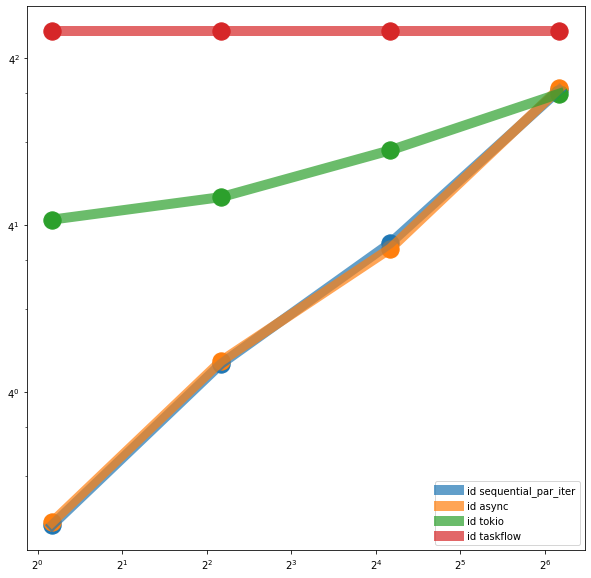

In [19]:
#['512-600', '64-800', '64-96', '512-24', '32-1200', 
# '128-240', '32-4800', '32-12', '128-1200', '256-48', '64-360', '512-48', 
# '32-12000', '128-600', '256-24', '128-48', '128-2400', '128-120', '32-240', 
# '32-120', '128-9600', '64-120', '512-120', '256-2400', '256-4800', '512-96', 
# '64-2400', '256-120', '64-600', '128-96', '32-9600', '32-2400', '256-96', '256-600', 
# '32-24', '128-12', '64-4800', '256-12', '32-48', '32-600', '128-24', '64-24', '64-48', 
# '32-96', '256-240', '64-9600', '64-240', '32-360', '64-12000', '512-12', '256-9600', 
# '64-1200', '64-12', '256-800', '256-360', '128-4800', '512-360', '256-1200', '512-240', 
# '128-800', '512-800', '128-360', '32-800', '128-12000', '256-12000']



b = list(map(lambda value: value[value.value.str.contains(r",*-12$")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()

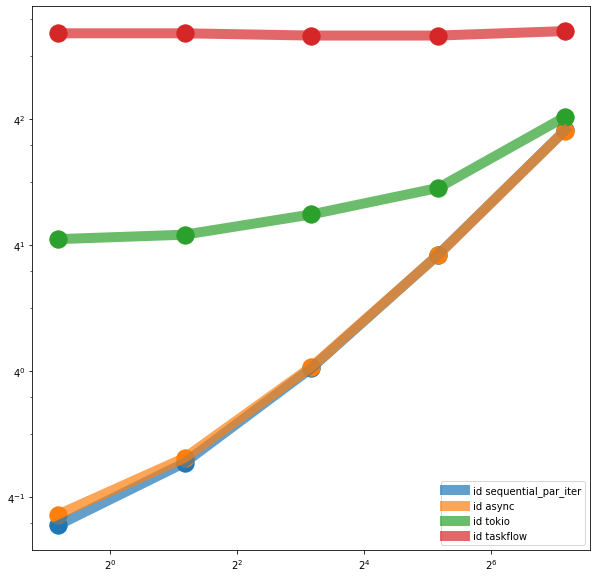

In [20]:
#['512-600', '64-800', '64-96', '512-24', '32-1200', 
# '128-240', '32-4800', '32-12', '128-1200', '256-48', '64-360', '512-48', 
# '32-12000', '128-600', '256-24', '128-48', '128-2400', '128-120', '32-240', 
# '32-120', '128-9600', '64-120', '512-120', '256-2400', '256-4800', '512-96', 
# '64-2400', '256-120', '64-600', '128-96', '32-9600', '32-2400', '256-96', '256-600', 
# '32-24', '128-12', '64-4800', '256-12', '32-48', '32-600', '128-24', '64-24', '64-48', 
# '32-96', '256-240', '64-9600', '64-240', '32-360', '64-12000', '512-12', '256-9600', 
# '64-1200', '64-12', '256-800', '256-360', '128-4800', '512-360', '256-1200', '512-240', 
# '128-800', '512-800', '128-360', '32-800', '128-12000', '256-12000']



b = list(map(lambda value: value[value.value.str.contains(r",*-24$")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()

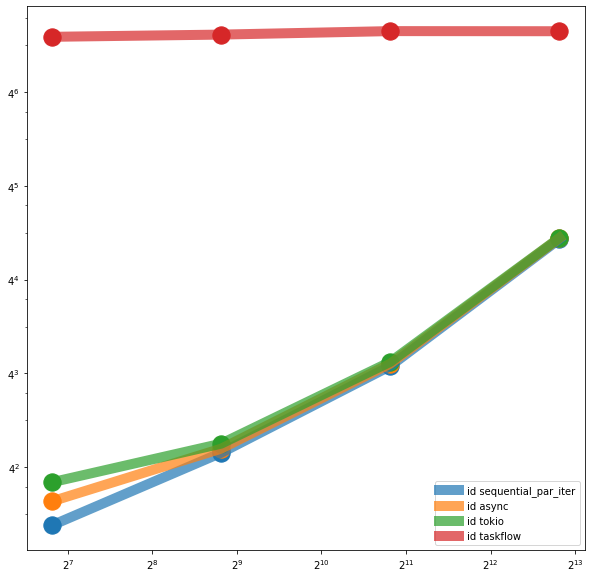

In [21]:
#['512-600', '64-800', '64-96', '512-24', '32-1200', 
# '128-240', '32-4800', '32-12', '128-1200', '256-48', '64-360', '512-48', 
# '32-12000', '128-600', '256-24', '128-48', '128-2400', '128-120', '32-240', 
# '32-120', '128-9600', '64-120', '512-120', '256-2400', '256-4800', '512-96', 
# '64-2400', '256-120', '64-600', '128-96', '32-9600', '32-2400', '256-96', '256-600', 
# '32-24', '128-12', '64-4800', '256-12', '32-48', '32-600', '128-24', '64-24', '64-48', 
# '32-96', '256-240', '64-9600', '64-240', '32-360', '64-12000', '512-12', '256-9600', 
# '64-1200', '64-12', '256-800', '256-360', '128-4800', '512-360', '256-1200', '512-240', 
# '128-800', '512-800', '128-360', '32-800', '128-12000', '256-12000']



b = list(map(lambda value: value[value.value.str.contains(r",*-4800$")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()

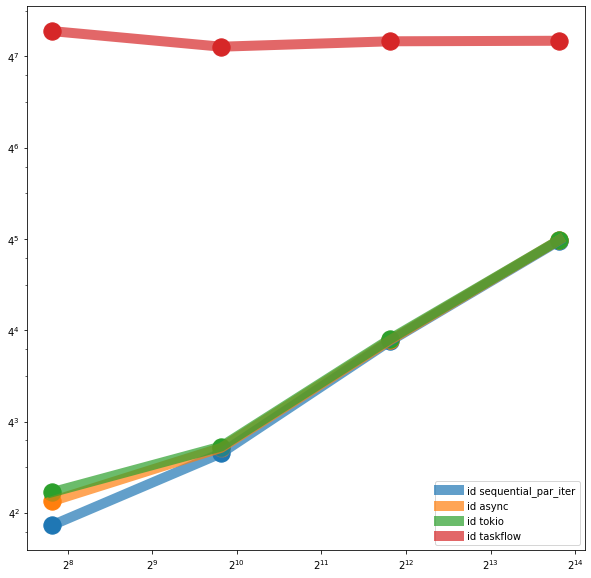

In [31]:
#['512-600', '64-800', '64-96', '512-24', '32-1200', 
# '128-240', '32-4800', '32-12', '128-1200', '256-48', '64-360', '512-48', 
# '32-12000', '128-600', '256-24', '128-48', '128-2400', '128-120', '32-240', 
# '32-120', '128-9600', '64-120', '512-120', '256-2400', '256-4800', '512-96', 
# '64-2400', '256-120', '64-600', '128-96', '32-9600', '32-2400', '256-96', '256-600', 
# '32-24', '128-12', '64-4800', '256-12', '32-48', '32-600', '128-24', '64-24', '64-48', 
# '32-96', '256-240', '64-9600', '64-240', '32-360', '64-12000', '512-12', '256-9600', 
# '64-1200', '64-12', '256-800', '256-360', '128-4800', '512-360', '256-1200', '512-240', 
# '128-800', '512-800', '128-360', '32-800', '128-12000', '256-12000']



b = list(map(lambda value: value[value.value.str.contains(r",*-9600$")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()

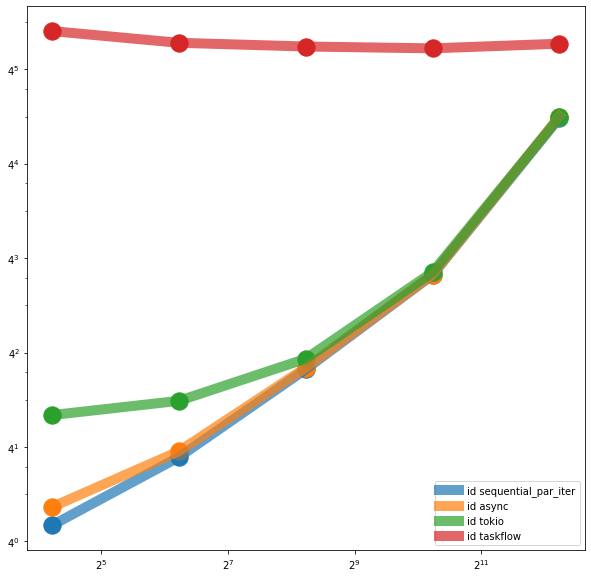

In [23]:
#['512-600', '64-800', '64-96', '512-24', '32-1200', 
# '128-240', '32-4800', '32-12', '128-1200', '256-48', '64-360', '512-48', 
# '32-12000', '128-600', '256-24', '128-48', '128-2400', '128-120', '32-240', 
# '32-120', '128-9600', '64-120', '512-120', '256-2400', '256-4800', '512-96', 
# '64-2400', '256-120', '64-600', '128-96', '32-9600', '32-2400', '256-96', '256-600', 
# '32-24', '128-12', '64-4800', '256-12', '32-48', '32-600', '128-24', '64-24', '64-48', 
# '32-96', '256-240', '64-9600', '64-240', '32-360', '64-12000', '512-12', '256-9600', 
# '64-1200', '64-12', '256-800', '256-360', '128-4800', '512-360', '256-1200', '512-240', 
# '128-800', '512-800', '128-360', '32-800', '128-12000', '256-12000']



b = list(map(lambda value: value[value.value.str.contains(r",*-800$")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()

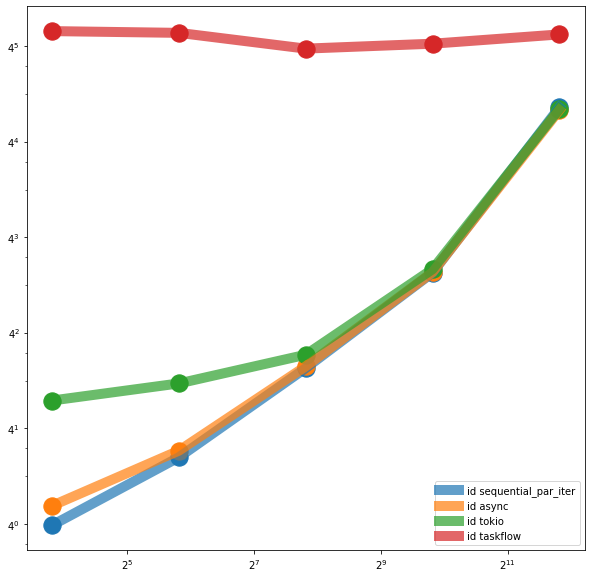

In [24]:
#['512-600', '64-800', '64-96', '512-24', '32-1200', 
# '128-240', '32-4800', '32-12', '128-1200', '256-48', '64-360', '512-48', 
# '32-12000', '128-600', '256-24', '128-48', '128-2400', '128-120', '32-240', 
# '32-120', '128-9600', '64-120', '512-120', '256-2400', '256-4800', '512-96', 
# '64-2400', '256-120', '64-600', '128-96', '32-9600', '32-2400', '256-96', '256-600', 
# '32-24', '128-12', '64-4800', '256-12', '32-48', '32-600', '128-24', '64-24', '64-48', 
# '32-96', '256-240', '64-9600', '64-240', '32-360', '64-12000', '512-12', '256-9600', 
# '64-1200', '64-12', '256-800', '256-360', '128-4800', '512-360', '256-1200', '512-240', 
# '128-800', '512-800', '128-360', '32-800', '128-12000', '256-12000']



b = list(map(lambda value: value[value.value.str.contains(r",*-600$")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()

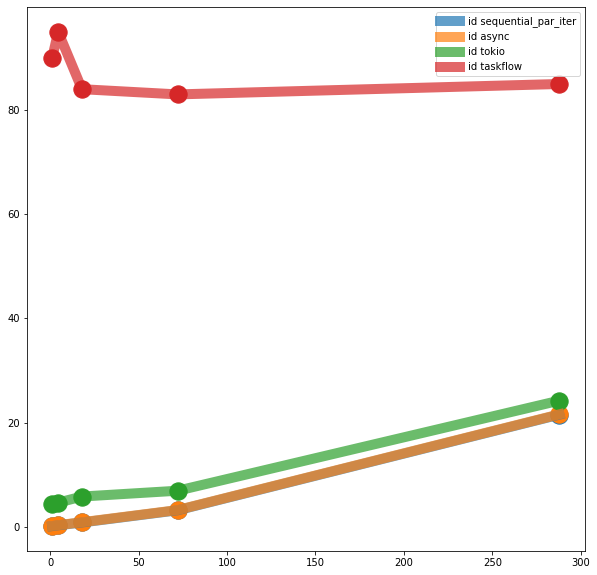

In [29]:
#['512-600', '64-800', '64-96', '512-24', '32-1200', 
# '128-240', '32-4800', '32-12', '128-1200', '256-48', '64-360', '512-48', 
# '32-12000', '128-600', '256-24', '128-48', '128-2400', '128-120', '32-240', 
# '32-120', '128-9600', '64-120', '512-120', '256-2400', '256-4800', '512-96', 
# '64-2400', '256-120', '64-600', '128-96', '32-9600', '32-2400', '256-96', '256-600', 
# '32-24', '128-12', '64-4800', '256-12', '32-48', '32-600', '128-24', '64-24', '64-48', 
# '32-96', '256-240', '64-9600', '64-240', '32-360', '64-12000', '512-12', '256-9600', 
# '64-1200', '64-12', '256-800', '256-360', '128-4800', '512-360', '256-1200', '512-240', 
# '128-800', '512-800', '128-360', '32-800', '128-12000', '256-12000']



b = list(map(lambda value: value[value.value.str.contains(r",*-48$")] ,l))
#print(b)
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
#plt.xscale('log',base=2) 
#plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()

In [36]:
b = list(map(lambda value: value[value.value.str.contains(r"512-.*$")] ,l))
#print(b)

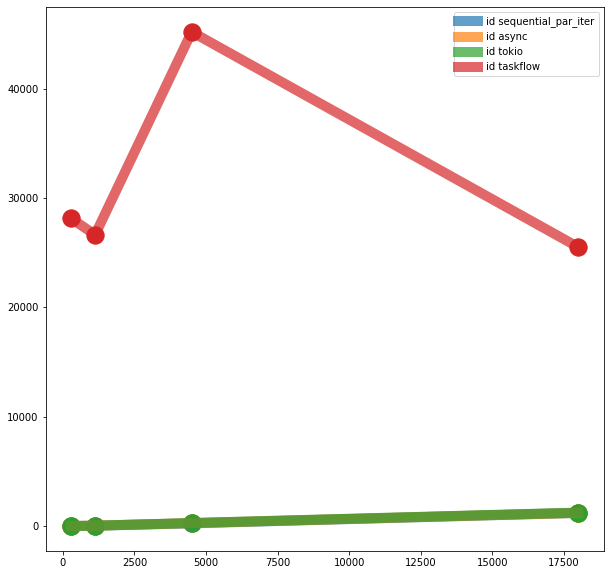

In [35]:
b = list(map(lambda value: value[value.value.str.contains(r",*-12000$")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
#plt.xscale('log',base=2) 
#plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()